# STOCK SENTIMENT

Predicting market behavior from tweets

Students:
* Thiago Bellas - 20231131
* Renato Morais - 20231135

-----------------------------------------------------------------------

## Importação de dados

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import plotly.graph_objects as go
import plotly.express as px

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from yellowbrick import ClassBalance
from wordcloud import WordCloud,STOPWORDS

# Disable all warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\tbellas\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# read csv files using Pandas and stored in variables called data_train and data_test
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [3]:
# Checking the data in Data_train and Data_test
print(f'O DataFrame "data_train": {data_train.shape[0]} rows and {data_train.shape[1]} columns.')
print(f'O DataFrame "data_test": {data_test.shape[0]} rows and {data_test.shape[1]} columns.')

O DataFrame "data_train": 9543 rows and 2 columns.
O DataFrame "data_test": 2388 rows and 2 columns.


In [4]:
# top 10 rows
data_train.head(10)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0
5,$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7Fv1ZiFZBS,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone estimate after Foxconn delay https://t.co/rlnEwzlzzS,0


-----------------------------------------------------------------------

# Initial Analysis

## Target variable (label)

In [5]:
# Check out if there are null values
data_train['label'].isnull().sum()

0

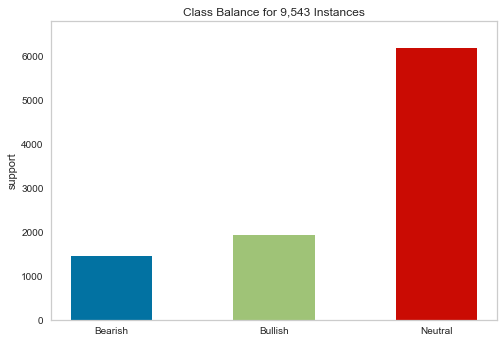

The classification is splited in 3 buckets: [0 1 2]:
0 - Bearish
1 - Bullish
2 - Neutral
Total 0 - Bearish in data train: 1442
Total 1 - Bullish in data train: 1923
Total 2 - Neutral in data train: 6178


In [6]:
# Plot 1
sentimento = ClassBalance(labels=['Bearish', 'Bullish', 'Neutral'])
sentimento.fit(data_train['label'])
sentimento.ax.grid(False)

sentimento.show();



# Visualizing the unique values from Target Variable
print(f"The classification is splited in 3 buckets: {(data_train['label']).unique()}:\n0 - Bearish\n1 - Bullish\n2 - Neutral")
print(f"Total 0 - Bearish in data train: {data_train['label'].eq(0).sum()}")
print(f"Total 1 - Bullish in data train: {data_train['label'].eq(1).sum()}")
print(f"Total 2 - Neutral in data train: {data_train['label'].eq(2).sum()}")

In [ ]:
# Plot 2 -  Funel graph
rotulos = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
contagem_valores = data_train['label'].value_counts()

# Mapping index of labels
contagem_valores.index = contagem_valores.index.map(rotulos)

# Plot
grafico = go.Figure(
    go.Funnelarea(
        text=contagem_valores.index,
        values=contagem_valores.values,
        title={'text':'Distribuição dos sentimentos', 'position':'top center'}
    )
)

grafico.show()

In [ ]:
# statistical describe measures of target valiable in Data train.
data_train['label'].describe()

-----------------------------------------------------------------------

## Variável independente (text)

Wordcounts

In [7]:
# Splitting text and after to split the text, add a new column with the word count
data_train['word_count']  = data_train['text'].apply(lambda x: len(str(x).split(" ")))

In [8]:
data_train.head()

,text,label,word_count
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0,10
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0,14
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0,7
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0,10


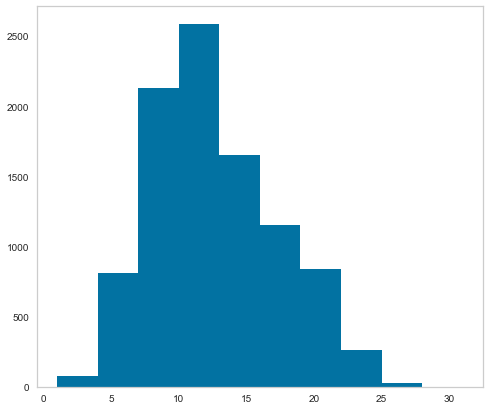

In [9]:
# histogram with how many row (axis X) and how many words (axis Y)
data_train['word_count'].hist(figsize=(8, 7), grid=False);

In [10]:
# Working with "join" using space as delimiter and counting the frequency of each word.
all_words = ' '.join(data_train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
dtype: int64

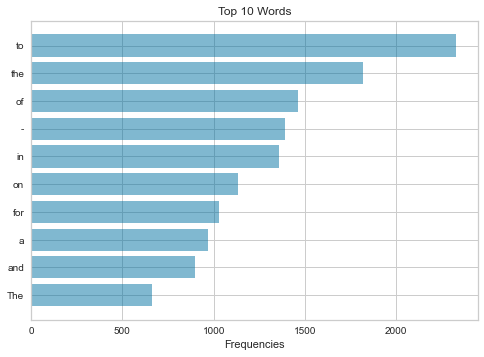

In [11]:
# Ploting the frenquency of each top 10 words
freq_sorted = freq.sort_values(ascending=True)

x_labels = freq_sorted.index[-10:]
values = freq_sorted[-10:]
plt.barh(x_labels, values, align='center', alpha=0.5)
plt.xlabel('Frequencies')
plt.title('Top 10 Words')
plt.show()

In [12]:
# display the main statistics of "word_count"
data_train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

Word clouds

In [ ]:
# Separation of texts labeled as "bullish" (1) and "bearish" (0)
train_bullish = data_train[data_train['label'] == 1]
train_bullish = train_bullish['text']
train_bearish = data_train[data_train['label'] == 0]
train_bearish = train_bearish['text']

# Function to draw and display a word cloud
def wordcloud_draw(data, color = 'black'):
    # Combines all texts into a single string
    words = ' '.join(data)
    # Cleans the string by removing certain unwanted words and patterns
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    # Cria a nuvem de palavras usando a biblioteca WordCloud
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    # Create the word cloud using the WordCloud library
    plt.figure(1,figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

# Generation and display of the word cloud for texts labeled as "bullish"
print("Bullish words")
wordcloud_draw(train_bullish,'white')
# Word cloud generation and display for texts labeled as "bearish"
print("Bearish words")
wordcloud_draw(train_bearish)

In [ ]:
# chart to check outliers
px.box(data_train,
       x='label',
       y='word_count',
       color='label',
       title='Quantidade Palavras por Sentimento')

In [ ]:
# Filter the data
filtro1 = data_train[(data_train['word_count'].isin([31, 25])) & (data_train['label'] == 0)]

# Number of outliers for the label=1
filtro1

In [ ]:
# Filter the data
filtro2 = data_train[(data_train['word_count'].isin([27, 25, 24, 23, 22])) & (data_train['label'] == 1)]

# View the results
filtro2

In [ ]:
# Número de outliers para o label=1
filtro2.shape

In [ ]:
# Filtrar os dados
filtro3 = data_train[(data_train['word_count'].isin([29, 27])) & (data_train['label'] == 2)]

# Visualizar os resultados
filtro3

-----------------------------------------------------------------------

# 1) Pre-processing

To pre-processing data in the project we created one function with the following steps:

   * Remove URLs
   * Remove Tickers (Identified by $ + some words as pattern)
   * Remove extra spaces
   * Remove patterns with @ or #
   * Remove repeated puntuactions
   * Convert all words to lower case
   * Identify and remove contractions
   * Remove punctuation excluding stopwords

## 1.2) Data cleaning

Pre-Process Function

In [13]:
#!pip install contractions
#!pip install emoji --upgrade

import re
import string
import contractions
import emoji
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Função para demojizar emojis e remover caracteres não alfanuméricos após demojização
def demojize_and_clean(tweet):
    tweet = emoji.demojize(tweet)
    tweet = re.sub('[^a-zA-Z0-9\s]', '', tweet)  # Remove caracteres não alfanuméricos
    return tweet

# Função para pré-processamento e limpeza do texto
def pre_processing_cleaning(text, default_replace=""):
    # 1) Remove URLs
    text = re.sub('(http|https):\/\/\S+', default_replace, text)
    # 2) Remove patterns starting with $ (Tickers)
    text = re.sub('\$\S+', '', text)
    # 3) Remove extra spaces between sentences
    text = re.sub('\s*-\s*', '', text)
    # 4) Remove patterns starting with @ or #
    text = re.sub('[@#]\w+', default_replace, text)
    # 5) Remove repeated punctuations
    text = re.sub('[\?\.\!]+(?=[\?\.\!])', default_replace, text)
    # 6) Remove commas
    text = text.replace(',', '')
    # 7) Convert to lowercase
    text = text.lower()
    # 8) Fix contractions expressions
    text = contractions.fix(text)
    # 9) Remove punctuation excluding stopwords
    punc_exclude = set(string.punctuation)
    text = ''.join([word for word in text if word not in punc_exclude])
    # 10) Set Stop words to variable (sw_exclude)
    sw_exclude = set(stopwords.words('english'))
    # 11) Apply sw_exclude to text cleaned column
    text = ' '.join([word for word in text.split() if word not in sw_exclude])
    # 12) Demojize and remove caracteres não alfanuméricos após demojização
    text = demojize_and_clean(text)

    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tbellas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
from tqdm import tqdm
tqdm.pandas()

data_train['text_cleaned'] = data_train['text'].progress_apply(pre_processing_cleaning)

100%|██████████| 9543/9543 [00:07<00:00, 1303.58it/s]


In [15]:
data_train.head()

,text,label,word_count,text_cleaned
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0,10,jpmorgan reels expectations beyond meat
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0,14,nomura points bookings weakness carnival royal caribbean
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0,14,cemex cut credit suisse jp morgan weak building outlook
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0,7,btig research cuts neutral
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0,10,funko slides piper jaffray pt cut


In [16]:
data_train.tail()

,text,label,word_count,text_cleaned
9538,The Week's Gainers and Losers on the Stoxx Europe 50 --Dec. 2-6 #economy #MarketScreener https://t.co/iK5MO4NhQq https://t.co/AJh5V5fWTT,2,16,weeks gainers losers stoxx europe 50dec 26
9539,Tupperware Brands among consumer gainers; Unilever leads the losers,2,9,tupperware brands among consumer gainers unilever leads losers
9540,vTv Therapeutics leads healthcare gainers; Myomo and Biohaven Pharmaceutical among losers,2,11,vtv therapeutics leads healthcare gainers myomo biohaven pharmaceutical among losers
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,9,work xpo pyx amkr among hour movers
9542,"YNDX, I, QD and OESX among tech movers",2,8,yndx qd oesx among tech movers


## 1.3) Tokenization

Tokenize sentences

In [17]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tbellas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
data_train['text_cleaned'] = data_train['text_cleaned'].progress_apply(word_tokenize)

100%|██████████| 9543/9543 [00:01<00:00, 6233.59it/s]


In [19]:
data_train.head()

,text,label,word_count,text_cleaned
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0,10,"[jpmorgan, reels, expectations, beyond, meat]"
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0,14,"[nomura, points, bookings, weakness, carnival, royal, caribbean]"
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0,14,"[cemex, cut, credit, suisse, jp, morgan, weak, building, outlook]"
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0,7,"[btig, research, cuts, neutral]"
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0,10,"[funko, slides, piper, jaffray, pt, cut]"


In [20]:
data_train.tail()

,text,label,word_count,text_cleaned
9538,The Week's Gainers and Losers on the Stoxx Europe 50 --Dec. 2-6 #economy #MarketScreener https://t.co/iK5MO4NhQq https://t.co/AJh5V5fWTT,2,16,"[weeks, gainers, losers, stoxx, europe, 50dec, 26]"
9539,Tupperware Brands among consumer gainers; Unilever leads the losers,2,9,"[tupperware, brands, among, consumer, gainers, unilever, leads, losers]"
9540,vTv Therapeutics leads healthcare gainers; Myomo and Biohaven Pharmaceutical among losers,2,11,"[vtv, therapeutics, leads, healthcare, gainers, myomo, biohaven, pharmaceutical, among, losers]"
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,9,"[work, xpo, pyx, amkr, among, hour, movers]"
9542,"YNDX, I, QD and OESX among tech movers",2,8,"[yndx, qd, oesx, among, tech, movers]"


## 1.4) Lemmatization

Stemmer and Lemmatizer

Analyzing differences between Stemmer and Lemmatizer

In [21]:
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [22]:
list_of_words = data_train['text_cleaned'][0]

In [23]:
import nltk
nltk.download('wordnet')
for word in list_of_words:
    print(list_of_words)
    print(f"Lemma of {word} is {lemma.lemmatize(word)}")
    print(f"Stem of {word} is {stemmer.stem(word)}")
    print('--------------------New word----------------')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tbellas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['jpmorgan', 'reels', 'expectations', 'beyond', 'meat']
Lemma of jpmorgan is jpmorgan
Stem of jpmorgan is jpmorgan
--------------------New word----------------
['jpmorgan', 'reels', 'expectations', 'beyond', 'meat']
Lemma of reels is reel
Stem of reels is reel
--------------------New word----------------
['jpmorgan', 'reels', 'expectations', 'beyond', 'meat']
Lemma of expectations is expectation
Stem of expectations is expect
--------------------New word----------------
['jpmorgan', 'reels', 'expectations', 'beyond', 'meat']
Lemma of beyond is beyond
Stem of beyond is beyond
--------------------New word----------------
['jpmorgan', 'reels', 'expectations', 'beyond', 'meat']
Lemma of meat is meat
Stem of meat is meat
--------------------New word----------------


In [24]:
# Function Lemma
def apply_lemma(text):
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word) for word in text]
    return ' '.join(lemma_words)

In [25]:
# After applying Lemm, add the column with the new words
data_train['lemma_text'] = data_train['text_cleaned'].progress_apply(apply_lemma)

100%|██████████| 9543/9543 [00:00<00:00, 14433.82it/s]


In [26]:
data_train.head()

,text,label,word_count,text_cleaned,lemma_text
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0,10,"[jpmorgan, reels, expectations, beyond, meat]",jpmorgan reel expectation beyond meat
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0,14,"[nomura, points, bookings, weakness, carnival, royal, caribbean]",nomura point booking weakness carnival royal caribbean
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0,14,"[cemex, cut, credit, suisse, jp, morgan, weak, building, outlook]",cemex cut credit suisse jp morgan weak building outlook
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0,7,"[btig, research, cuts, neutral]",btig research cut neutral
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0,10,"[funko, slides, piper, jaffray, pt, cut]",funko slide piper jaffray pt cut


In [27]:
data_train.tail()

,text,label,word_count,text_cleaned,lemma_text
9538,The Week's Gainers and Losers on the Stoxx Europe 50 --Dec. 2-6 #economy #MarketScreener https://t.co/iK5MO4NhQq https://t.co/AJh5V5fWTT,2,16,"[weeks, gainers, losers, stoxx, europe, 50dec, 26]",week gainer loser stoxx europe 50dec 26
9539,Tupperware Brands among consumer gainers; Unilever leads the losers,2,9,"[tupperware, brands, among, consumer, gainers, unilever, leads, losers]",tupperware brand among consumer gainer unilever lead loser
9540,vTv Therapeutics leads healthcare gainers; Myomo and Biohaven Pharmaceutical among losers,2,11,"[vtv, therapeutics, leads, healthcare, gainers, myomo, biohaven, pharmaceutical, among, losers]",vtv therapeutic lead healthcare gainer myomo biohaven pharmaceutical among loser
9541,"WORK, XPO, PYX and AMKR among after hour movers",2,9,"[work, xpo, pyx, amkr, among, hour, movers]",work xpo pyx amkr among hour mover
9542,"YNDX, I, QD and OESX among tech movers",2,8,"[yndx, qd, oesx, among, tech, movers]",yndx qd oesx among tech mover


In [28]:
data_train['text_cleaned'] = data_train['lemma_text']

In [29]:
data_train.drop('lemma_text', axis=1, inplace=True)


In [30]:
data_train.head()

,text,label,word_count,text_cleaned
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0,10,jpmorgan reel expectation beyond meat
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0,14,nomura point booking weakness carnival royal caribbean
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0,14,cemex cut credit suisse jp morgan weak building outlook
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0,7,btig research cut neutral
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0,10,funko slide piper jaffray pt cut


In [31]:
data_train['text_cleaned'] = data_train['text_cleaned'].progress_apply(word_tokenize)

100%|██████████| 9543/9543 [00:01<00:00, 5438.70it/s]


In [32]:
data_train.head()

,text,label,word_count,text_cleaned
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,0,10,"[jpmorgan, reel, expectation, beyond, meat]"
1,$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3,0,14,"[nomura, point, booking, weakness, carnival, royal, caribbean]"
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb",0,14,"[cemex, cut, credit, suisse, jp, morgan, weak, building, outlook]"
3,$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N,0,7,"[btig, research, cut, neutral]"
4,$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB,0,10,"[funko, slide, piper, jaffray, pt, cut]"


In [33]:
data_train['text_cleaned']

0                                                       [jpmorgan, reel, expectation, beyond, meat]
1                                    [nomura, point, booking, weakness, carnival, royal, caribbean]
2                                 [cemex, cut, credit, suisse, jp, morgan, weak, building, outlook]
3                                                                    [btig, research, cut, neutral]
4                                                           [funko, slide, piper, jaffray, pt, cut]
                                                   ...                                             
9538                                                [week, gainer, loser, stoxx, europe, 50dec, 26]
9539                            [tupperware, brand, among, consumer, gainer, unilever, lead, loser]
9540    [vtv, therapeutic, lead, healthcare, gainer, myomo, biohaven, pharmaceutical, among, loser]
9541                                                     [work, xpo, pyx, amkr, among, hour, mover]


___________________________________________________________________________________________

Stemming

We decide to move forward with Lemmatization due to when we compared both sentences chances we notice some loss of meaning in Lemmatization output

In [34]:
# Function Stemming
"""
def apply_stemming(text):
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    return ' '.join(stemmed_words)

# After applying stem, add the column with the new words
data_train['Stemmed_text'] = data_train['Text_Cleaned_Without_stop_words'].apply(apply_stemming)
"""

"\ndef apply_stemming(text):\n    stemmer = SnowballStemmer('english')\n    stemmed_words = [stemmer.stem(word) for word in text]\n    return ' '.join(stemmed_words)\n\n# After applying stem, add the column with the new words\ndata_train['Stemmed_text'] = data_train['Text_Cleaned_Without_stop_words'].apply(apply_stemming)\n"

# 2) Features engineering functions

## 2.1) Bag-of-Words

In [35]:
corpus = data_train['text_cleaned']

In [36]:
from sklearn.feature_extraction.text import CountVectorizer

In [37]:
# create a fit_cv function used to build the Bag-of-Word vectorizer with the corpus
def fit_cv(tweet_corpus):
  cv_vect = CountVectorizer(tokenizer=lambda x: x,
                           preprocessor=lambda x: x)
  cv_vect.fit(tweet_corpus)
  return cv_vect

In [38]:
# Use the fit_cv function to fit the vectorizer on the corpus
cv_vect = fit_cv(corpus)

In [39]:
# Get the vectorizer features (matrix columns)
ft = cv_vect.get_feature_names_out()

In [40]:
print('There are {} features in this corpus'.format(len(ft)))
print(ft)

There are 14460 features in this corpus
['0' '00' '000' ... 'zyen' 'zynex' 'zynga']


In [41]:
# Convert the corpus to a matrix by using the vectorize
cv_mtx = cv_vect.transform(corpus)

In [42]:
# print the matrix shape
print('Matrix shape is: {}'.format(cv_mtx.shape))

Matrix shape is: (9543, 14460)


In [43]:
# convert the matrix to an array
cv_mtx.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## 2.2) TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [45]:
# create a fit_tfidf function to build the TF-IDF vectorizer with the corpus
def fit_tfidf(tweet_corpus):
  tf_vect = TfidfVectorizer(preprocessor = lambda x: x,
                            tokenizer = lambda x: x)
  tf_vect.fit(tweet_corpus)
  return tf_vect

In [46]:
# Use the fit_cv function to fit  the vectorizer on the corpus, and transform the corpus
tf_vect = fit_tfidf(corpus)
tf_mtx = tf_vect.transform(corpus)

In [47]:
# Get the vectorizer features (matrix columns)
ft = tf_vect.get_feature_names_out()

In [48]:
print('There are {} features in this corpus'.format(len(ft)))
print(ft)

There are 14460 features in this corpus
['0' '00' '000' ... 'zyen' 'zynex' 'zynga']


In [49]:
# print the matrix shape
print(tf_mtx.shape)

(9543, 14460)


In [50]:
# convert the matrix to an array
tf_mtx.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## 2.3) Word2Vec

In [51]:
import gensim.downloader

### Set model "glove-twitter-25"

In [52]:
w2v = gensim.downloader.load('glove-twitter-25')

### Model Input with Word2vec | 'glove-twitter-25'

In [53]:
def word_2_vec(corpus, w2v_model, vector_size):
    doc_vec = []

    for document in tqdm(corpus):
        sentence_vector = np.zeros(vector_size)
        count = 0

        for word in document:
            if word in w2v_model.index_to_key:
                count += 1
                sentence_vector = np.add(sentence_vector, w2v_model.word_vec(word))

        # Check if count is higher than zero before the average
        if count > 0:
            avg_vector = sentence_vector / count
        else:
            avg_vector = sentence_vector

        doc_vec.append(avg_vector)

    return np.array(doc_vec)


# 3) Train and test split

### 3.1) Original dataset

In [54]:
# Splitting features X and y to train
from sklearn.model_selection import train_test_split

X = data_train['text_cleaned']
y = data_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)

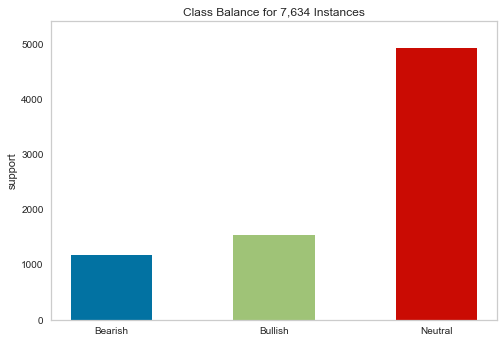

The classification is splited in 3 buckets: [0 1 2]:
0 - Bearish
1 - Bullish
2 - Neutral
Total 0 - Bearish in data train: 1165
Total 1 - Bullish in data train: 1545
Total 2 - Neutral in data train: 4924


In [55]:
# Plot 1
sentimento = ClassBalance(labels=['Bearish', 'Bullish', 'Neutral'])
sentimento.fit(y_train)
sentimento.ax.grid(False)

sentimento.show();



# Visualizing the unique values from Target Variable
print(f"The classification is splited in 3 buckets: {(data_train['label']).unique()}:\n0 - Bearish\n1 - Bullish\n2 - Neutral")
print(f"Total 0 - Bearish in data train: {y_train.eq(0).sum()}")
print(f"Total 1 - Bullish in data train: {y_train.eq(1).sum()}")
print(f"Total 2 - Neutral in data train: {y_train.eq(2).sum()}")

In [56]:
# Display the shapes of the training and testing sets for features and target variable
print(f"Shape of x_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print('')
print(f"Shape of x_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (7634,)
Shape of y_train: (7634,)

Shape of x_test: (1909,)
Shape of y_test: (1909,)


In [57]:
import random
id = random.randint(0, len(X_train) - 1)
print('Train tweet: {}'.format(X_train.iloc[id]))
print('Sentiment: {}'.format(y_train.iloc[id]))

Train tweet: ['cybersecurity', 'expert', 'launch', 'crosspoint', 'capital', 'partner']
Sentiment: 2


### 3.2) Balanced Dataset

In [58]:
from imblearn.under_sampling import RandomUnderSampler

In [59]:
# Converter a Series para um array NumPy
X_train_array = np.array(X_train).reshape(-1, 1)

In [60]:
# Instanciar o objeto RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Aplicar o under-sampling aos dados
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train_array.reshape(-1, 1), y_train)

# Utilizar np.squeeze para remover a dimensão extra
X_train_resampled = np.squeeze(X_train_resampled)

# Verificar as novas formas dos dados
print("Shape of x_train_resampled:", X_train_resampled.shape)
print("Shape of y_train_resampled:", y_train_resampled.shape)


Shape of x_train_resampled: (3495,)
Shape of y_train_resampled: (3495,)


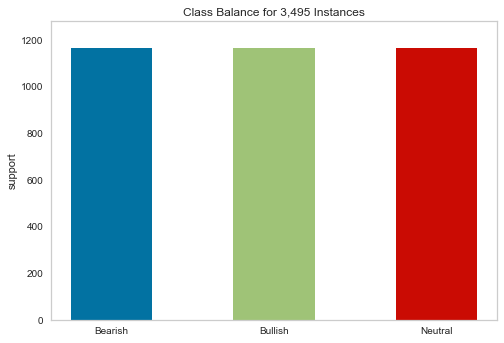

The classification is splited in 3 buckets: [0 1 2]:
0 - Bearish
1 - Bullish
2 - Neutral
Total 0 - Bearish in data train: 1165
Total 1 - Bullish in data train: 1165
Total 2 - Neutral in data train: 1165


In [61]:
# Plot 1
sentimento = ClassBalance(labels=['Bearish', 'Bullish', 'Neutral'])
sentimento.fit(y_train_resampled)
sentimento.ax.grid(False)

sentimento.show();



# Visualizing the unique values from Target Variable
print(f"The classification is splited in 3 buckets: {(y_train_resampled).unique()}:\n0 - Bearish\n1 - Bullish\n2 - Neutral")
print(f"Total 0 - Bearish in data train: {y_train_resampled.eq(0).sum()}")
print(f"Total 1 - Bullish in data train: {y_train_resampled.eq(1).sum()}")
print(f"Total 2 - Neutral in data train: {y_train_resampled.eq(2).sum()}")

# 4) Classification models

This function will be used to plot the confusion matrix for the different models we will create

In [62]:
import seaborn as sn

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn

## 4.1) Logistic Regression (LR)

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
# Function to set and train the logistic regression model
def fit_lr(X_train, y_train):
  model = LogisticRegression(max_iter=1000, solver='lbfgs')
  model.fit(X_train, y_train)
  return model

### Model construction

##### Training the model with Bag of Words

###### Original dataset

In [65]:
# Use the function above (1.5 Bag of Words) to fit and train data to build the Bag-of-Words vectorizer
cv = fit_cv(X_train)
X_train_BoW = cv.transform(X_train)
X_test_BoW = cv.transform(X_test)

In [66]:
# Call the Logistic Regression function to fit it with BoW data
model_lr_BoW = fit_lr(X_train_BoW, y_train)

###### Balanced Dataset

In [67]:
# Use the function above (1.5 Bag of Words) to fit and train data to build the Bag-of-Words vectorizer
cv = fit_cv(X_train_resampled)
X_train_resampled_BoW = cv.transform(X_train_resampled)
X_test_resambled_BoW = cv.transform(X_test)

In [68]:
# Call the Logistic Regression function to fit it with BoW data
model_lr_BoW_resample = fit_lr(X_train_resampled_BoW, y_train_resampled)

##### Training the model with TF-IDF

###### Original Dataset

In [69]:
# Use the function above (1.6 Bag of Words) to fit and train data to build the TF-IDF vectorizer
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [70]:
# # Call the Logistic Regression function to fit it with TF-IDF data
model_lr_tf = fit_lr(X_train_tf, y_train)

###### Balanced Dataset

In [71]:
# Use the function above (1.6 Bag of Words) to fit and train data to build the TF-IDF vectorizer
tf = fit_tfidf(X_train_resampled)
X_train_resambled_tf = tf.transform(X_train_resampled)
X_test_resampled_tf = tf.transform(X_test)

In [72]:
# # Call the Logistic Regression function to fit it with TF-IDF data
model_lr_tf_resampled = fit_lr(X_train_resambled_tf, y_train_resampled)

##### Training the model with Word2Vec

###### Original Dataset

In [73]:
# Splitting features X_w2v and y_w2v to train

X_w2v = data_train['text_cleaned']
y_w2v = data_train['label']

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.20, random_state=4)

In [74]:
X_train_clean_w2v = word_2_vec(X_train_w2v, w2v, 25)

100%|██████████| 7634/7634 [05:04<00:00, 25.03it/s]


In [75]:
X_test_clean_w2v = word_2_vec(X_test_w2v, w2v, 25)

100%|██████████| 1909/1909 [01:07<00:00, 28.21it/s]


In [76]:
len(X_train_clean_w2v)

7634

In [77]:
len(X_test_clean_w2v)

1909

In [78]:
X_train_clean_w2v[200]

array([-0.3936478 ,  0.35705493, -0.20627699, -0.09910221,  0.19857941,
       -0.3869817 ,  0.3608987 , -1.23232099,  0.21991201,  0.125033  ,
        0.11569831,  0.2455684 , -2.63159997,  0.3087019 ,  0.221879  ,
       -0.01767   ,  0.31652931,  0.0440096 ,  0.20839219, -0.236234  ,
        0.217271  ,  0.5556793 , -0.17920431, -0.98827098, -0.37602401])

In [79]:
X_test_clean_w2v[0]

array([ 0.19097267,  0.97596666, -0.70926482, -0.31577301,  0.41967434,
       -0.52180733,  0.39057934, -1.17470413,  0.0736285 , -0.35210312,
       -0.10724167,  0.21018666, -2.61571666,  0.59693167,  0.419174  ,
       -0.19373167, -0.24670333,  0.03424484,  0.58229833, -0.45993667,
       -0.38334333, -0.171598  , -0.47331184, -0.40500516, -0.68421435])

In [80]:
log_reg_w2v = LogisticRegression(max_iter=1000, solver='lbfgs')

In [81]:
log_reg_w2v.fit(X_train_clean_w2v, y_train)

LogisticRegression(max_iter=1000)

###### Balanced Dataset

In [82]:
# Converter a Series para um array NumPy
X_train_array = np.array(X_train_w2v).reshape(-1, 1)

In [83]:
# Instanciar o objeto RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Aplicar o under-sampling aos dados
X_train_w2v_resampled, y_train_w2v_resampled = under_sampler.fit_resample(X_train_array.reshape(-1, 1), y_train_w2v)

# Utilizar np.squeeze para remover a dimensão extra
X_train_w2v_resampled = np.squeeze(X_train_w2v_resampled)

# Verificar as novas formas dos dados
print("Shape of x_train_resampled:", X_train_w2v_resampled.shape)
print("Shape of y_train_resampled:", y_train_w2v_resampled.shape)

Shape of x_train_resampled: (3495,)
Shape of y_train_resampled: (3495,)


In [84]:
X_train_clean_w2v_resampled = word_2_vec(X_train_w2v_resampled, w2v, 25)

100%|██████████| 3495/3495 [02:16<00:00, 25.65it/s]


In [85]:
len(X_train_clean_w2v_resampled)

3495

In [86]:
log_reg_w2v_resampled = LogisticRegression(max_iter=1000, solver='lbfgs')

In [87]:
log_reg_w2v_resampled.fit(X_train_clean_w2v_resampled, y_train_resampled)

LogisticRegression(max_iter=1000)

### Performance metrics

In [88]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#### BoW

###### Original Dataset

In [89]:
# use the fitted model_lr_cv (BoW) to predict X_text
y_pred_lr_BoW = model_lr_BoW.predict(X_test_BoW)

In [90]:
print('Logistic Regression Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_lr_BoW)))

Logistic Regression Model Accuracy: 79.94%


In [91]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_lr_BoW, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.46      0.68      0.55       187
     Bullish       0.60      0.74      0.66       307
     Neutral       0.94      0.83      0.88      1415

    accuracy                           0.80      1909
   macro avg       0.66      0.75      0.70      1909
weighted avg       0.83      0.80      0.81      1909



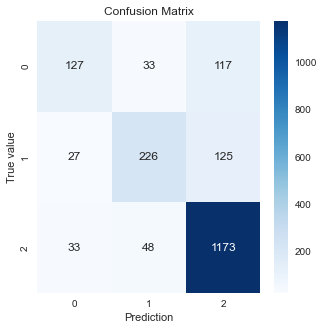

In [92]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_BoW));

###### Balanced Dataset

In [93]:
y_pred_lr_BoW_resample = model_lr_BoW_resample.predict(X_test_resambled_BoW)

In [94]:
print('Logistic Regression Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_lr_BoW_resample)))

Logistic Regression Model Accuracy: 72.18%


In [95]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_lr_BoW_resample, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.67      0.44      0.53       421
     Bullish       0.70      0.57      0.63       458
     Neutral       0.74      0.90      0.81      1030

    accuracy                           0.72      1909
   macro avg       0.70      0.64      0.66      1909
weighted avg       0.71      0.72      0.71      1909



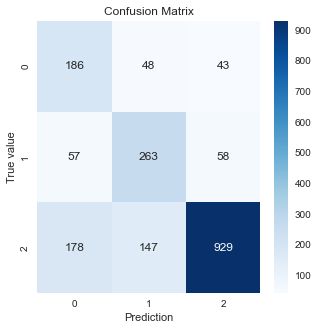

In [96]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_BoW_resample));

#### TF_IDF

###### Original Dataset

In [97]:
# use the fitted model_lr_cv (BoW) to predict X_text
y_pred_lr_tf = model_lr_tf.predict(X_test_tf)

In [98]:
print('Logistic Regression Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_lr_tf)))

Logistic Regression Model Accuracy: 78.21%


In [99]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_lr_tf, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.35      0.75      0.48       130
     Bullish       0.51      0.75      0.60       255
     Neutral       0.96      0.79      0.87      1524

    accuracy                           0.78      1909
   macro avg       0.61      0.76      0.65      1909
weighted avg       0.86      0.78      0.81      1909



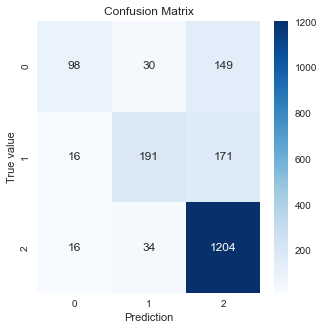

In [100]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_tf));

###### Balanced Dataset

In [101]:
# use the fitted model_lr_cv (BoW) to predict X_text
y_pred_lr_tf_resampled = model_lr_tf_resampled.predict(X_test_resampled_tf)

In [102]:
print('Logistic Regression Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_lr_tf_resampled)))

Logistic Regression Model Accuracy: 73.07%


In [103]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_lr_tf_resampled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.70      0.46      0.56       420
     Bullish       0.70      0.58      0.63       455
     Neutral       0.75      0.91      0.82      1034

    accuracy                           0.73      1909
   macro avg       0.71      0.65      0.67      1909
weighted avg       0.73      0.73      0.72      1909



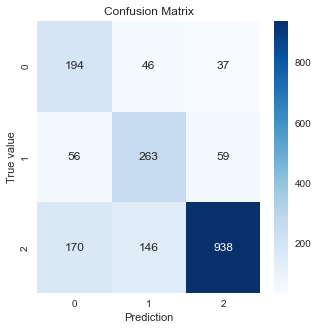

In [104]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_tf_resampled));

#### Word2Vec

###### Original Dataset

In [105]:
y_pred_lr_w2c = log_reg_w2v.predict(X_test_clean_w2v)

In [106]:
print('Logistic Regression Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_lr_w2c)))

Logistic Regression Model with Word2Vec Accuracy: 67.52%


In [107]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_lr_w2c, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.06      0.35      0.10        49
     Bullish       0.22      0.50      0.31       170
     Neutral       0.95      0.70      0.81      1690

    accuracy                           0.68      1909
   macro avg       0.41      0.52      0.41      1909
weighted avg       0.86      0.68      0.74      1909



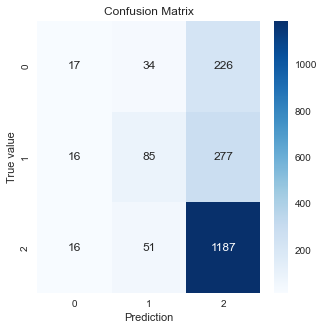

In [108]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_w2c));

###### Balanced Dataset

In [109]:
y_pred_lr_w2c_resambled = log_reg_w2v.predict(X_test_clean_w2v)

In [110]:
print('Logistic Regression Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_lr_w2c_resambled)))

Logistic Regression Model with Word2Vec Accuracy: 67.52%


In [111]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_lr_w2c_resambled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.06      0.35      0.10        49
     Bullish       0.22      0.50      0.31       170
     Neutral       0.95      0.70      0.81      1690

    accuracy                           0.68      1909
   macro avg       0.41      0.52      0.41      1909
weighted avg       0.86      0.68      0.74      1909



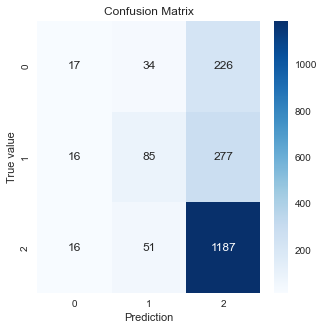

In [112]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_w2c_resambled));

### Cross Validation (K-folds)

In [113]:
from sklearn.model_selection import cross_val_score, KFold

def perform_cross_validation(model, X, y, representation_name):
    kfold = KFold(n_splits=10, shuffle=True, random_state=5)
    results = cross_val_score(model, X, y, cv=kfold)
    average_accuracy = results.mean() * 100.0
    print(f"{representation_name} Average accuracy: {average_accuracy:.2f}%")

###### Original Dataset

In [114]:
# Assuming X_train_BoW, X_train_tf, X_train_clean_w2v are defined
model = LogisticRegression(max_iter=1000, solver='sag')

perform_cross_validation(model, X_train_BoW, y_train, "BoW")
perform_cross_validation(model, X_train_tf, y_train, "TF-IDF")
perform_cross_validation(model, X_train_clean_w2v, y_train, "Word2Vec")

BoW Average accuracy: 78.49%
TF-IDF Average accuracy: 76.45%
Word2Vec Average accuracy: 65.71%


###### Balanced Dataset

In [115]:
perform_cross_validation(model, X_train_resampled_BoW, y_train_resampled, "BoW Balanced Dataset")
perform_cross_validation(model, X_train_resambled_tf, y_train_resampled, "TF-IDF Balanced Dataset")
perform_cross_validation(model, X_train_clean_w2v_resampled, y_train_resampled, "Word2Vec Balanced Dataset")

BoW Balanced Dataset Average accuracy: 68.38%
TF-IDF Balanced Dataset Average accuracy: 68.24%
Word2Vec Balanced Dataset Average accuracy: 50.38%


## 4.2) K-Nearest Neighbors | KNN

In [116]:
from sklearn.neighbors import KNeighborsClassifier

In [117]:
def fit_knn(X_train, y_train):
  model_knn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')
  model_knn.fit(X_train, y_train)
  return model_knn

### Model construction

##### Training the model with Bag of Words

###### Original Dataset

In [118]:
# código igual ao da LR
# use the fit_cv function on training data to build the Bag-of-Words vectorizer
cv = fit_cv(X_train)
X_train_BoW = cv.transform(X_train)
X_test_BoW = cv.transform(X_test)

In [119]:
# Fit the KNN model on training data by using the fit_knn function
model_knn_BoW = fit_knn(X_train_BoW, y_train)

###### Balanced Dataset

In [120]:
# Call the Logistic Regression function to fit it with BoW data
model_knn_BoW_resample = fit_knn(X_train_resampled_BoW, y_train_resampled)

In [121]:
X_train_resampled_BoW.shape

(3495, 7343)

##### Training the model with TF-IDF

###### Original Dataset

In [122]:
# use the fit_cv function on training data to build the TF-IDF vectorizer
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [123]:
# Fit the KNN model on training data by using the fit_knn function
model_knn_tf = fit_knn(X_train_tf, y_train)

###### Balanced Dataset

In [124]:
# # Call the Logistic Regression function to fit it with TF-IDF data
model_knn_tf_resampled = fit_knn(X_train_resambled_tf, y_train_resampled)

##### Training the model with Word2Vec

###### Original Dataset

In [125]:
model_knn_w2v = fit_knn(X_train_clean_w2v, y_train)

###### Balanced Dataset

In [126]:
model_knn_w2v_resampled = fit_knn(X_train_clean_w2v_resampled, y_train_resampled)

### Performance metrics

#### BoW

###### Original Dataset

In [127]:
# use the fitted model_knn_cv (BoW) to predict X_text
y_pred_knn_BoW = model_knn_BoW.predict(X_test_BoW)

In [128]:
print('KNN Model with Bag of Words Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_knn_BoW)))

KNN Model with Bag of Words Accuracy: 77.27%


In [129]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_knn_BoW, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.36      0.65      0.47       156
     Bullish       0.59      0.66      0.62       337
     Neutral       0.92      0.81      0.86      1416

    accuracy                           0.77      1909
   macro avg       0.62      0.71      0.65      1909
weighted avg       0.81      0.77      0.79      1909



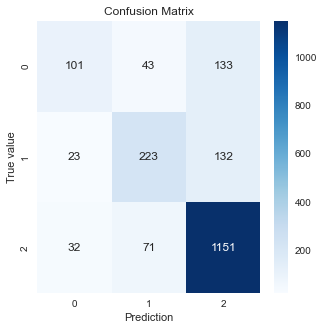

In [130]:
plot_confusion(confusion_matrix(y_test, y_pred_knn_BoW));

###### Balanced Dataset

In [131]:
y_pred_knn_BoW_resample = model_knn_BoW_resample.predict(X_test_resambled_BoW)

In [132]:
print('KNN Model with Bag of Words Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_knn_BoW_resample)))

KNN Model with Bag of Words Accuracy: 62.02%


In [133]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_knn_BoW_resample, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.60      0.35      0.44       468
     Bullish       0.74      0.45      0.56       616
     Neutral       0.59      0.90      0.71       825

    accuracy                           0.62      1909
   macro avg       0.64      0.57      0.57      1909
weighted avg       0.64      0.62      0.60      1909



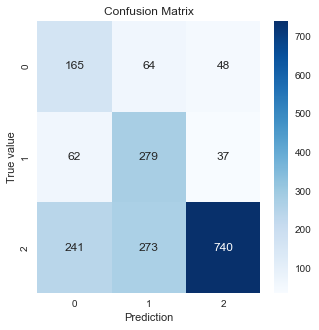

In [134]:
plot_confusion(confusion_matrix(y_test, y_pred_knn_BoW_resample));

#### TF_IDF

###### Original Dataset

In [135]:
# use the fitted model_knn_tf (TF-IDF) to predict X_text
y_pred_knn_tf = model_knn_tf.predict(X_test_tf)

In [136]:
print('KNN Model with TF-IDF Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_knn_tf)))

KNN Model with TF-IDF Accuracy: 77.74%


In [137]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_knn_tf, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.40      0.67      0.50       164
     Bullish       0.61      0.66      0.63       347
     Neutral       0.91      0.82      0.86      1398

    accuracy                           0.78      1909
   macro avg       0.64      0.72      0.66      1909
weighted avg       0.81      0.78      0.79      1909



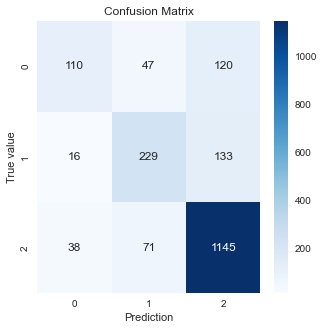

In [138]:
plot_confusion(confusion_matrix(y_test, y_pred_knn_tf));

###### Balanced Dataset

In [139]:
y_pred_knn_tf_resampled = model_knn_tf_resampled.predict(X_test_resampled_tf)

In [140]:
print('KNN Model with TF-IDF Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_knn_tf_resampled)))

KNN Model with TF-IDF Accuracy: 62.02%


In [141]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_knn_tf_resampled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.64      0.38      0.47       473
     Bullish       0.75      0.45      0.56       631
     Neutral       0.58      0.90      0.70       805

    accuracy                           0.62      1909
   macro avg       0.66      0.57      0.58      1909
weighted avg       0.65      0.62      0.60      1909



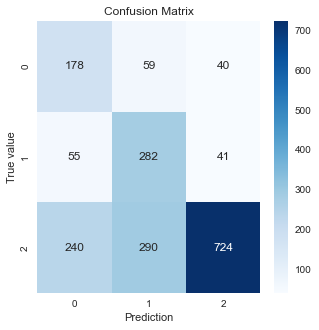

In [142]:
plot_confusion(confusion_matrix(y_test, y_pred_knn_tf_resampled));

#### Word2Vec

###### Original Dataset

In [143]:
y_pred_knn_w2v = model_knn_w2v.predict(X_test_clean_w2v)

In [144]:
print(' K-Nearest Neighbors Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_knn_w2v)))

 K-Nearest Neighbors Model with Word2Vec Accuracy: 70.19%


In [145]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_knn_w2v, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.22      0.54      0.32       115
     Bullish       0.38      0.51      0.44       279
     Neutral       0.91      0.75      0.82      1515

    accuracy                           0.70      1909
   macro avg       0.50      0.60      0.52      1909
weighted avg       0.79      0.70      0.73      1909



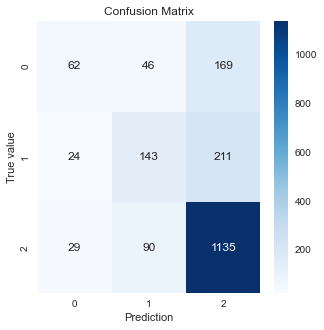

In [146]:
plot_confusion(confusion_matrix(y_test, y_pred_knn_w2v));

###### Balanced Dataset

In [147]:
y_pred_knn_w2c_resambled = model_knn_w2v.predict(X_test_clean_w2v)

In [148]:
print('Logistic Regression Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_knn_w2c_resambled)))

Logistic Regression Model with Word2Vec Accuracy: 70.19%


In [149]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_knn_w2c_resambled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.22      0.54      0.32       115
     Bullish       0.38      0.51      0.44       279
     Neutral       0.91      0.75      0.82      1515

    accuracy                           0.70      1909
   macro avg       0.50      0.60      0.52      1909
weighted avg       0.79      0.70      0.73      1909



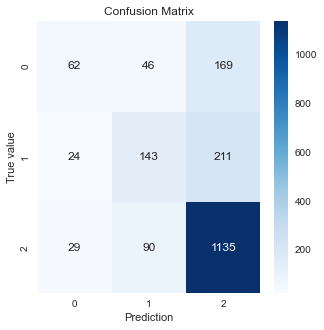

In [150]:
plot_confusion(confusion_matrix(y_test, y_pred_knn_w2c_resambled));

### Cross Validation (K-folds)

In [151]:
# Assuming X_train_BoW, X_train_tf, X_train_clean_w2v are defined
model = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

perform_cross_validation(model, X_train_BoW, y_train, "BoW")
perform_cross_validation(model, X_train_tf, y_train, "TF-IDF")
perform_cross_validation(model, X_train_clean_w2v, y_train, "Word2Vec")

BoW Average accuracy: 75.65%
TF-IDF Average accuracy: 76.67%
Word2Vec Average accuracy: 69.48%


In [152]:
perform_cross_validation(model, X_train_resampled_BoW, y_train_resampled, "BoW Balanced Dataset")
perform_cross_validation(model, X_train_resambled_tf, y_train_resampled, "TF-IDF Balanced Dataset")
perform_cross_validation(model, X_train_clean_w2v_resampled, y_train_resampled, "Word2Vec Balanced Dataset")

BoW Balanced Dataset Average accuracy: 61.60%
TF-IDF Balanced Dataset Average accuracy: 61.55%
Word2Vec Balanced Dataset Average accuracy: 52.19%


## 4.3) Naive-Bayes

In [153]:
from sklearn.naive_bayes import MultinomialNB

In [154]:
def fit_nb(X_train, y_train):
  model_nb = MultinomialNB()
  model_nb.fit(X_train, y_train)
  return model_nb

### Model construction

##### Training the model with Bag of Words

###### Original Dataaset

In [155]:
# código igual ao da LR
# use the fit_cv function on training data to build the Bag-of-Words vectorizer
cv = fit_cv(X_train)
X_train_BoW = cv.transform(X_train)
X_test_BoW = cv.transform(X_test)

In [156]:
# Fit the NB model on training data by using the fit_nb function
model_nb_BoW = fit_nb(X_train_BoW, y_train)

###### Original Dataaset

In [157]:
# Call the Logistic Regression function to fit it with BoW data
model_nb_BoW_resample = fit_nb(X_train_resampled_BoW, y_train_resampled)

##### Training the model with TF-IDF

###### Original Dataaset

In [158]:
# use the fit_tfidf function on training data to build the TF-IDF vectorizer
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [159]:
# Fit the KNN model on training data by using the fit_nb function
model_nb_tf = fit_nb(X_train_tf, y_train)

###### Balanced Dataaset

In [160]:
model_nb_tf_resampled = fit_nb(X_train_resambled_tf, y_train_resampled)

##### Training the model with Word2Vec

###### Original Dataset

In [161]:
from sklearn.naive_bayes import GaussianNB

# Instanciar e treinar o modelo Naive Bayes
model_nb_w2v = GaussianNB()

In [162]:
X_train_clean_w2v_adj_nb = np.mean(X_train_clean_w2v, axis=1)

# Reshape para torná-lo uma matriz 2D
X_train_clean_w2v_adj_nb_2d = X_train_clean_w2v_adj_nb.reshape(-1, 1)

In [163]:
model_nb_w2v.fit(X_train_clean_w2v_adj_nb_2d, y_train)

GaussianNB()

###### Balanced Dataaset

In [164]:
X_train_clean_w2v_adj_nb_resampled = np.mean(X_train_clean_w2v_resampled, axis=1)

# Reshape para torná-lo uma matriz 2D
X_train_clean_w2v_adj_nb_2d_resampled = X_train_clean_w2v_adj_nb_resampled.reshape(-1, 1)

In [165]:
model_nb_w2v.fit(X_train_clean_w2v_adj_nb_2d_resampled, y_train_resampled)

GaussianNB()

### Performance metrics

#### BoW

###### Original Dataset

In [166]:
# use the fitted model_nb_cv (BoW) to predict X_text
y_pred_nb_BoW = model_nb_BoW.predict(X_test_BoW)

In [167]:
print('Naive Bayes Model with Bog of Words Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_nb_BoW)))

Naive Bayes Model with Bog of Words Accuracy: 78.52%


In [168]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_nb_BoW, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.43      0.70      0.53       170
     Bullish       0.60      0.68      0.64       335
     Neutral       0.92      0.82      0.87      1404

    accuracy                           0.79      1909
   macro avg       0.65      0.73      0.68      1909
weighted avg       0.82      0.79      0.80      1909



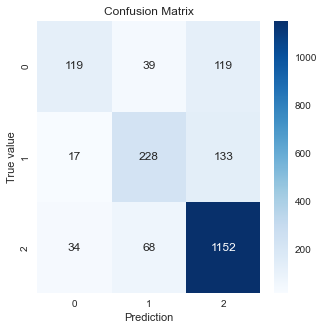

In [169]:
plot_confusion(confusion_matrix(y_test, y_pred_nb_BoW));

###### Balanced dataset

In [170]:
y_pred_nb_BoW_resample = model_nb_BoW_resample.predict(X_test_resambled_BoW)

In [171]:
print('KNN Model with Bag of Words Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_nb_BoW_resample)))

KNN Model with Bag of Words Accuracy: 66.00%


In [172]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_nb_BoW_resample, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.70      0.38      0.49       508
     Bullish       0.74      0.51      0.61       549
     Neutral       0.63      0.92      0.75       852

    accuracy                           0.66      1909
   macro avg       0.69      0.60      0.61      1909
weighted avg       0.68      0.66      0.64      1909



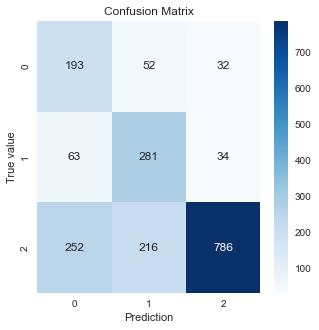

In [173]:
plot_confusion(confusion_matrix(y_test, y_pred_nb_BoW_resample));

#### TF_IDF

###### Original Dataset

In [174]:
# use the fitted model_nb_cv (BoW) to predict X_text
y_pred_nb_tf = model_nb_tf.predict(X_test_tf)

In [175]:
print('Naive Bayes Model with TF-IDF Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_nb_tf)))

Naive Bayes Model with TF-IDF Accuracy: 71.77%


In [176]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_nb_tf, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.05      0.93      0.09        14
     Bullish       0.29      0.84      0.43       130
     Neutral       1.00      0.71      0.83      1765

    accuracy                           0.72      1909
   macro avg       0.44      0.82      0.45      1909
weighted avg       0.94      0.72      0.79      1909



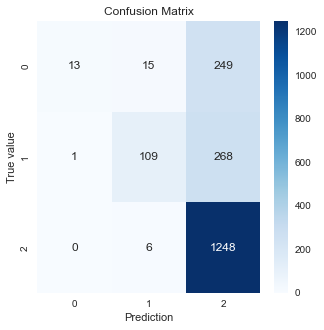

In [177]:
plot_confusion(confusion_matrix(y_test, y_pred_nb_tf));

###### Balanced Dataset

In [178]:
y_pred_nb_tf_resampled = model_nb_tf_resampled.predict(X_test_resampled_tf)

In [179]:
print('KNN Model with TF-IDF Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_nb_tf_resampled)))

KNN Model with TF-IDF Accuracy: 65.22%


In [180]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_nb_tf_resampled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.69      0.38      0.49       508
     Bullish       0.76      0.50      0.60       579
     Neutral       0.61      0.93      0.74       822

    accuracy                           0.65      1909
   macro avg       0.69      0.60      0.61      1909
weighted avg       0.68      0.65      0.63      1909



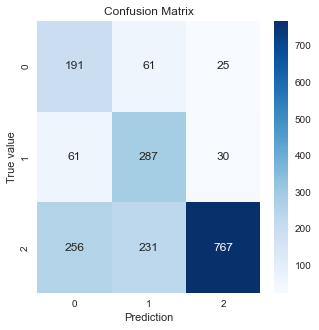

In [181]:
plot_confusion(confusion_matrix(y_test, y_pred_nb_tf_resampled));

#### Word2Vec

###### Origianl Datatset

In [182]:
from sklearn.naive_bayes import GaussianNB

In [183]:
nb_w2v = GaussianNB()


In [184]:
nb_w2v.fit(X_train_clean_w2v, y_train)

GaussianNB()

In [185]:
y_pred_nb_w2v = nb_w2v.predict(X_test_clean_w2v)

In [186]:
print(' Naive Bayes Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_nb_w2v)))

 Naive Bayes Model with Word2Vec Accuracy: 64.06%


In [187]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_nb_w2v, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.20      0.31      0.24       175
     Bullish       0.46      0.42      0.44       410
     Neutral       0.79      0.75      0.77      1324

    accuracy                           0.64      1909
   macro avg       0.48      0.50      0.48      1909
weighted avg       0.67      0.64      0.65      1909



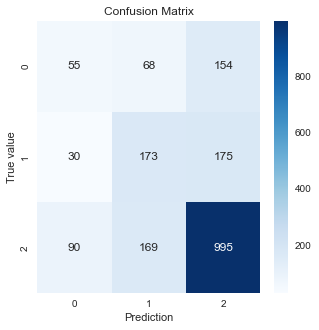

In [188]:
plot_confusion(confusion_matrix(y_test, y_pred_nb_w2v));

###### Balanced Dataset

In [189]:
# Calcular a média dos vetores de palavras para cada documento nos dados de teste
X_test_clean_w2v_adj_nb = np.mean(X_test_clean_w2v, axis=1)

# Reshape para torná-lo uma matriz 2D
X_test_clean_w2v_adj_nb_2d = X_test_clean_w2v_adj_nb.reshape(-1, 1)

In [190]:
# Fazer previsões
y_pred_nb_w2v_resampled = model_nb_w2v.predict(X_test_clean_w2v_adj_nb_2d)

In [191]:
print('Logistic Regression Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_nb_w2v_resampled)))

Logistic Regression Model with Word2Vec Accuracy: 38.24%


In [192]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_nb_w2v_resampled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.64      0.19      0.29       931
     Bullish       0.16      0.21      0.18       300
     Neutral       0.39      0.73      0.51       678

    accuracy                           0.38      1909
   macro avg       0.40      0.37      0.33      1909
weighted avg       0.47      0.38      0.35      1909



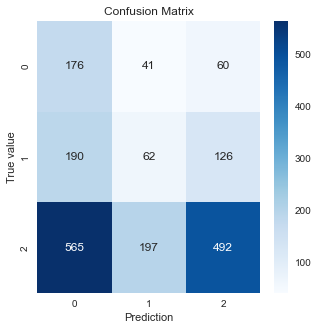

In [193]:
plot_confusion(confusion_matrix(y_test, y_pred_nb_w2v_resampled));

### Cross Validation (K-folds)

In [194]:

# Assuming X_train_BoW, X_train_tf, X_train_clean_w2v are defined
model = MultinomialNB()
model_w2v = GaussianNB()
perform_cross_validation(model, X_train_BoW, y_train, "BoW")
perform_cross_validation(model, X_train_tf, y_train, "TF-IDF")
perform_cross_validation(model_w2v, X_train_clean_w2v, y_train, "Word2Vec")

BoW Average accuracy: 73.88%
TF-IDF Average accuracy: 70.40%
Word2Vec Average accuracy: 63.09%


In [195]:
perform_cross_validation(model, X_train_resampled_BoW, y_train_resampled, "BoW Balanced Dataset")
perform_cross_validation(model, X_train_resambled_tf, y_train_resampled, "TF-IDF Balanced Dataset")
perform_cross_validation(model_w2v, X_train_clean_w2v_resampled, y_train_resampled, "Word2Vec Balanced Dataset")

BoW Balanced Dataset Average accuracy: 66.58%
TF-IDF Balanced Dataset Average accuracy: 66.61%
Word2Vec Balanced Dataset Average accuracy: 48.98%


## 4.4) Random Forest

In [196]:
from sklearn.ensemble import RandomForestClassifier

In [197]:
def fit_rf(X_train, y_train):
  model_rf = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state = 0, max_depth=4)
  model_rf.fit(X_train, y_train)
  return model_rf

### Model construction

##### Training the model with Bag of Words

###### Original Dataset

In [198]:
# código igual ao da LR
# use the fit_cv function on training data to build the Bag-of-Words vectorizer
cv = fit_cv(X_train)
X_train_Bow = cv.transform(X_train)
X_test_BoW = cv.transform(X_test)

In [199]:
# Fit the Random Forest model on training data by using the fit_rf function
model_rf_BoW = fit_rf(X_train_BoW, y_train)

###### Balanced Dataset

In [200]:
# Call the Logistic Regression function to fit it with BoW data
model_rf_BoW_resample = fit_nb(X_train_resampled_BoW, y_train_resampled)

##### Training the model with TF-IDF

###### Original Dataset

In [201]:
# use the fit_tfidf function on training data to build the TF-IDF vectorizer
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [202]:
# Fit the Random Forest model on training data by using the fit_rf function
model_rf_tf = fit_rf(X_train_tf, y_train)

###### Balanced Dataset

In [203]:
model_rf_tf_resampled = fit_rf(X_train_resambled_tf, y_train_resampled)

##### Training the model with Word2Vec

###### Original Dataset

In [204]:
model_rf_w2v = fit_rf(X_train_clean_w2v, y_train)

###### Balanced Dataset

In [205]:
model_rf_w2v_resampled = fit_rf(X_train_clean_w2v_resampled, y_train_resampled)

### Performance metrics

#### BoW

###### Original Dataset

In [206]:
# use the fitted model_rf_cv (BoW) to predict X_text
y_pred_rf_Bow = model_rf_BoW.predict(X_test_BoW)

In [207]:
print('LR Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_rf_Bow)))

LR Model Accuracy: 65.69%


In [208]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_rf_Bow, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00         0
     Bullish       0.00      0.00      0.00         0
     Neutral       1.00      0.66      0.79      1909

    accuracy                           0.66      1909
   macro avg       0.33      0.22      0.26      1909
weighted avg       1.00      0.66      0.79      1909



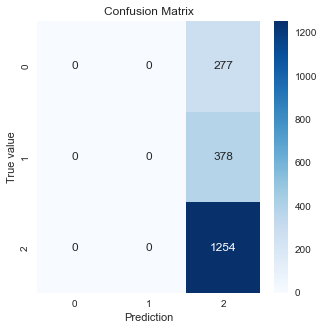

In [209]:
plot_confusion(confusion_matrix(y_test, y_pred_rf_Bow));

###### Balanced Dataset

In [210]:
y_pred_rf_BoW_resample = model_rf_BoW_resample.predict(X_test_resambled_BoW)

In [211]:
print('LR Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_rf_BoW_resample)))

LR Model Accuracy: 66.00%


In [212]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_rf_BoW_resample, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.70      0.38      0.49       508
     Bullish       0.74      0.51      0.61       549
     Neutral       0.63      0.92      0.75       852

    accuracy                           0.66      1909
   macro avg       0.69      0.60      0.61      1909
weighted avg       0.68      0.66      0.64      1909



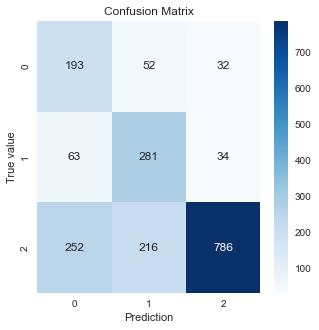

In [213]:
plot_confusion(confusion_matrix(y_test, y_pred_rf_BoW_resample));

#### TF_IDF

###### Original Dataset

In [214]:
# use the fitted model_rf_cv (BoW) to predict X_text
y_pred_rf_tf = model_rf_tf.predict(X_test_tf)

In [215]:
print('LR Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_rf_tf)))

LR Model Accuracy: 65.69%


In [216]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_rf_tf, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00         0
     Bullish       0.00      0.00      0.00         0
     Neutral       1.00      0.66      0.79      1909

    accuracy                           0.66      1909
   macro avg       0.33      0.22      0.26      1909
weighted avg       1.00      0.66      0.79      1909



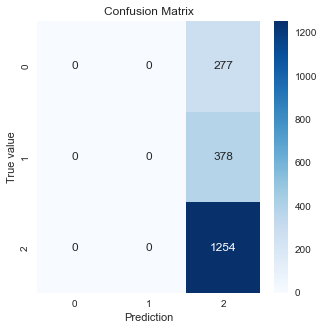

In [217]:
plot_confusion(confusion_matrix(y_test, y_pred_rf_tf));

###### Balanced Dataset

In [218]:
y_pred_rf_tf_resampled = model_rf_tf_resampled.predict(X_test_resampled_tf)

In [219]:
print('LR Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_rf_tf_resampled)))

LR Model Accuracy: 69.20%


In [220]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_rf_tf_resampled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.49      0.41      0.45       335
     Bullish       0.50      0.54      0.52       350
     Neutral       0.79      0.81      0.80      1224

    accuracy                           0.69      1909
   macro avg       0.60      0.59      0.59      1909
weighted avg       0.69      0.69      0.69      1909



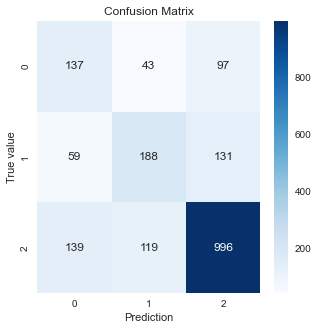

In [221]:
plot_confusion(confusion_matrix(y_test, y_pred_rf_tf_resampled));

#### Word2Vec

###### Original Dataset

In [222]:
rf_w2v = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state = 0, max_depth=4)

In [223]:
rf_w2v.fit(X_train_clean_w2v, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=150,
                       random_state=0)

In [224]:
y_pred_rf_w2v = rf_w2v.predict(X_test_clean_w2v)

In [225]:
print(' Random Forest Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_rf_w2v)))

 Random Forest Model with Word2Vec Accuracy: 65.69%


In [226]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_rf_w2v, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00         0
     Bullish       0.00      0.00      0.00         0
     Neutral       1.00      0.66      0.79      1909

    accuracy                           0.66      1909
   macro avg       0.33      0.22      0.26      1909
weighted avg       1.00      0.66      0.79      1909



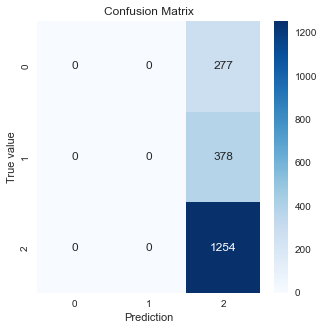

In [227]:
plot_confusion(confusion_matrix(y_test, y_pred_rf_w2v));

###### Balanced Dataset

In [228]:
# Calcular a média dos vetores de palavras para cada documento nos dados de teste
X_test_clean_w2v_adj_nb = np.mean(X_test_clean_w2v, axis=1)

# Reshape para torná-lo uma matriz 2D
X_test_clean_w2v_adj_nb_2d = X_test_clean_w2v_adj_nb.reshape(-1, 1)

# Se necessário, preencher para manter 25 features
# Isso depende de como os vetores de palavras foram originalmente criados
# Aqui estamos preenchendo com zeros, mas ajuste conforme necessário
X_test_clean_w2v_adj_nb_2d = np.hstack([X_test_clean_w2v_adj_nb_2d, np.zeros((X_test_clean_w2v_adj_nb_2d.shape[0], 24))])


In [229]:
# Fazer previsões
y_pred_nb_w2v_resampled = rf_w2v.predict(X_test_clean_w2v_adj_nb_2d)

In [230]:
print(' Random Forest Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_nb_w2v_resampled)))

 Random Forest Model with Word2Vec Accuracy: 65.69%


In [231]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_nb_w2v_resampled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00         0
     Bullish       0.00      0.00      0.00         0
     Neutral       1.00      0.66      0.79      1909

    accuracy                           0.66      1909
   macro avg       0.33      0.22      0.26      1909
weighted avg       1.00      0.66      0.79      1909



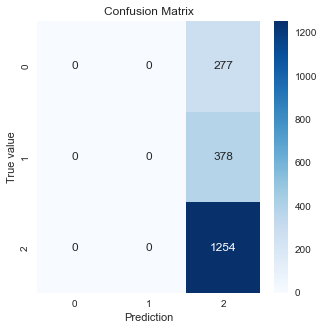

In [232]:
plot_confusion(confusion_matrix(y_test, y_pred_nb_w2v_resampled));

### Cross Validation (K-folds)

In [233]:
# Assuming X_train_BoW, X_train_tf, X_train_clean_w2v are defined
model = RandomForestClassifier(n_estimators=150, criterion='entropy', random_state = 0, max_depth=4)
perform_cross_validation(model, X_train_BoW, y_train, "BoW")
perform_cross_validation(model, X_train_tf, y_train, "TF-IDF")
perform_cross_validation(model, X_train_clean_w2v, y_train, "Word2Vec")

BoW Average accuracy: 64.50%
TF-IDF Average accuracy: 64.50%
Word2Vec Average accuracy: 64.53%


In [234]:
perform_cross_validation(model, X_train_resampled_BoW, y_train_resampled, "BoW Balanced Dataset")
perform_cross_validation(model, X_train_resambled_tf, y_train_resampled, "TF-IDF Balanced Dataset")
perform_cross_validation(model_w2v, X_train_clean_w2v_resampled, y_train_resampled, "Word2Vec Balanced Dataset")

BoW Balanced Dataset Average accuracy: 59.86%
TF-IDF Balanced Dataset Average accuracy: 59.34%
Word2Vec Balanced Dataset Average accuracy: 48.98%


## 4.5) Multilayer Perceptron - ANN

### Model construction

In [235]:
from sklearn.neural_network import MLPClassifier

In [236]:
def fit_mlp(X_train, y_train):
  model_mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)
  model_mlp.fit(X_train, y_train)
  return model_mlp

##### Training the model with Bag of Words

###### Original Dataset

In [237]:
# código igual ao da LR
# use the fit_cv function on training data to build the Bag-of-Words vectorizer
cv = fit_cv(X_train)
X_train_Bow = cv.transform(X_train)
X_test_BoW = cv.transform(X_test)

In [238]:
# Fit the MLP model on training data by using the fit_rf function
model_mlp_BoW = fit_mlp(X_train_BoW, y_train)

###### Balanced Dataset

In [239]:
# Call the Logistic Regression function to fit it with BoW data
model_mlp_BoW_resample = fit_mlp(X_train_resampled_BoW, y_train_resampled)

##### Training the model with TF-IDF

###### Original Dataset

In [240]:
# use the fit_tfidf function on training data to build the TF-IDF vectorizer
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

In [241]:
# Fit the MLP model on training data by using the fit_rf function
model_mlp_tf = fit_mlp(X_train_tf, y_train)

###### Balanced Dataset

In [242]:
model_mlp_tf_resampled = fit_mlp(X_train_resambled_tf, y_train_resampled)

##### Training the model with Word2Vec

###### Original Dataset

In [243]:
model_mlp_w2v = fit_mlp(X_train_clean_w2v, y_train)

###### Balanced Dataset

In [244]:
model_mlp_w2v_resampled = fit_mlp(X_train_clean_w2v_resampled, y_train_resampled)

### Performance metrics

#### BoW

###### Original Dataset

In [245]:
# use the fitted model_mlp_cv (BoW) to predict X_text
y_pred_mlp_Bow = model_mlp_BoW.predict(X_test_BoW)

In [246]:
print('MLP Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_mlp_Bow)))

MLP Model Accuracy: 71.77%


In [247]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_mlp_Bow, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.31      0.32      0.32       268
     Bullish       0.60      0.62      0.61       368
     Neutral       0.84      0.83      0.84      1273

    accuracy                           0.72      1909
   macro avg       0.58      0.59      0.59      1909
weighted avg       0.72      0.72      0.72      1909



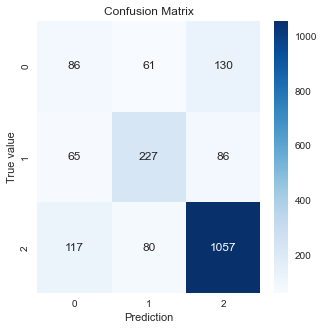

In [248]:
plot_confusion(confusion_matrix(y_test, y_pred_mlp_Bow));

###### Balaced Dataset

In [249]:
y_pred_mlp_BoW_resample = model_mlp_BoW_resample.predict(X_test_resambled_BoW)

In [250]:
print('MLP Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_mlp_BoW_resample)))

MLP Model Accuracy: 63.96%


In [251]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_mlp_BoW_resample, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.53      0.36      0.43       409
     Bullish       0.37      0.32      0.34       436
     Neutral       0.74      0.88      0.81      1064

    accuracy                           0.64      1909
   macro avg       0.55      0.52      0.53      1909
weighted avg       0.61      0.64      0.62      1909



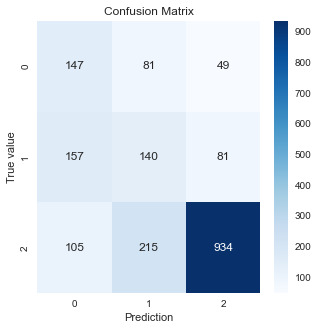

In [252]:
plot_confusion(confusion_matrix(y_test, y_pred_mlp_BoW_resample));

#### TF-IDF

###### Original Dataset

In [253]:
# use the fitted model_mlp_cv (BoW) to predict X_text
y_pred_mlp_tf = model_mlp_tf.predict(X_test_tf)

In [254]:
print('MLP Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_mlp_tf)))

MLP Model Accuracy: 73.34%


In [255]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_mlp_tf, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.35      0.35      0.35       275
     Bullish       0.60      0.64      0.62       354
     Neutral       0.86      0.84      0.85      1280

    accuracy                           0.73      1909
   macro avg       0.60      0.61      0.61      1909
weighted avg       0.74      0.73      0.74      1909



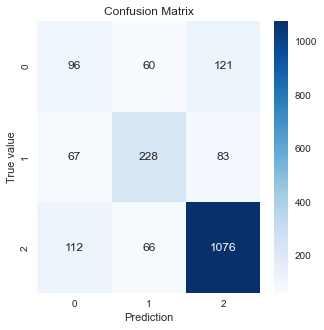

In [256]:
plot_confusion(confusion_matrix(y_test, y_pred_mlp_tf));

###### Balanced Dataset

In [257]:
y_pred_mlp_tf_resampled = model_mlp_tf_resampled.predict(X_test_resampled_tf)

In [258]:
print('MLP Model Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_mlp_tf_resampled)))

MLP Model Accuracy: 62.70%


In [259]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_mlp_tf_resampled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.53      0.39      0.45       381
     Bullish       0.40      0.30      0.34       506
     Neutral       0.72      0.88      0.79      1022

    accuracy                           0.63      1909
   macro avg       0.55      0.52      0.53      1909
weighted avg       0.60      0.63      0.60      1909



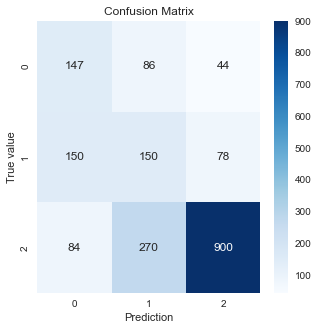

In [260]:
plot_confusion(confusion_matrix(y_test, y_pred_mlp_tf_resampled));

#### Word2Vec

###### Original Dataset

In [261]:
mlp_w2v = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)
model_mlp_w2v = mlp_w2v.fit(X_train_clean_w2v, y_train)

In [262]:
y_pred_mlp_w2v = mlp_w2v.predict(X_test_clean_w2v)

In [263]:
print('MLP Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_mlp_w2v)))

MLP Model with Word2Vec Accuracy: 67.89%


In [264]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_mlp_w2v, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00         0
     Bullish       0.27      0.48      0.35       215
     Neutral       0.95      0.70      0.81      1694

    accuracy                           0.68      1909
   macro avg       0.41      0.39      0.39      1909
weighted avg       0.87      0.68      0.76      1909



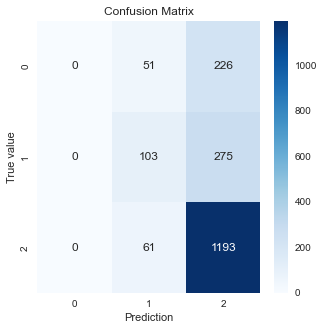

In [265]:
plot_confusion(confusion_matrix(y_test, y_pred_mlp_w2v));

###### Balanced Dataset

In [266]:
y_pred_mlp_w2c_resambled = model_mlp_w2v_resampled.predict(X_test_clean_w2v)

In [267]:
print('MLP Model with Word2Vec Accuracy: {:.2%}'.format(accuracy_score(y_test, y_pred_mlp_w2c_resambled)))

MLP Model with Word2Vec Accuracy: 58.20%


In [268]:
labels = {"Bearish":0, "Bullish":1, "Neutral":2}
print(classification_report(y_pred_mlp_w2c_resambled, y_test, target_names = labels.keys()))

              precision    recall  f1-score   support

     Bearish       0.06      0.12      0.08       141
     Bullish       0.63      0.36      0.46       663
     Neutral       0.68      0.77      0.73      1105

    accuracy                           0.58      1909
   macro avg       0.46      0.42      0.42      1909
weighted avg       0.62      0.58      0.58      1909



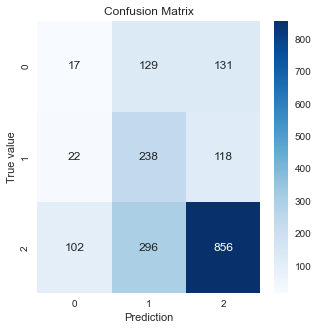

In [269]:
plot_confusion(confusion_matrix(y_test, y_pred_mlp_w2c_resambled));

### Cross Validation (K-folds)

In [270]:
# Assuming X_train_BoW, X_train_tf, X_train_clean_w2v are defined
model = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='logistic', random_state=1)
perform_cross_validation(model, X_train_BoW, y_train, "BoW")
perform_cross_validation(model, X_train_tf, y_train, "TF-IDF")
perform_cross_validation(model, X_train_clean_w2v, y_train, "Word2Vec")

BoW Average accuracy: 69.44%
TF-IDF Average accuracy: 70.33%
Word2Vec Average accuracy: 66.26%


In [ ]:
perform_cross_validation(model, X_train_resampled_BoW, y_train_resampled, "BoW Balanced Dataset")
perform_cross_validation(model, X_train_resambled_tf, y_train_resampled, "TF-IDF Balanced Dataset")
perform_cross_validation(model, X_train_clean_w2v_resampled, y_train_resampled, "Word2Vec Balanced Dataset")

# 5) Fazer previsões no data_test

In [271]:
# Pré-processamento no conjunto data_test
data_test['text_cleaned'] = data_test['text'].apply(pre_processing_cleaning)

In [272]:
data_test.head()

,id,text,text_cleaned
0,0,"ETF assets to surge tenfold in 10 years to $50 trillion, Bank of America predicts",etf assets surge tenfold 10 years trillion bank america predicts
1,1,Here’s What Hedge Funds Think Evolution Petroleum Corporation (EPM),hedge funds think evolution petroleum corporation epm
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Preview https://t.co/kNhCYwVnBX,phillipsvan heusen q3 2020 earnings preview
3,3,"China is in the process of waiving retaliatory tariffs on imports of U.S. pork and soy by domestic companies, a pro… https://t.co/08mZU9TrBX",china process waiving retaliatory tariffs imports yous pork soy domestic companies pro
4,4,"Highlight: “When growth is scarce, investors seem very willing to pay up for growth stock"" @PNCBank's… https://t.co/rO4fBOkBG9",highlight when growth scarce investors seem willing pay growth stock s


In [301]:
# Vetorização do conjunto data_test usando o vetorizador cv
X_test_cv = cv.transform(data_test['text_cleaned'])

# Previsões usando o modelo treinado model_lr_cv
y_pred_cv = model_lr_BoW.predict(X_test_cv)

"""
# Vetorização do conjunto data_test usando o vetorizador tf
X_test_tf = tf.transform(data_test['text_cleaned'])

# Previsões usando o modelo treinado model_lr_tf
y_pred_tf = model_lr_tf.predict(X_test_tf)"""

"\n# Vetorização do conjunto data_test usando o vetorizador tf\nX_test_tf = tf.transform(data_test['text_cleaned'])\n\n# Previsões usando o modelo treinado model_lr_tf\ny_pred_tf = model_lr_tf.predict(X_test_tf)"

In [302]:
# Adicionar as previsões usando o modelo Logistic Regression com Bag-of-Words (cv)
data_test['predicted_labels'] = y_pred_cv

# Ou, se você preferir usar TF-IDF:
# data_test['predictions_lr_tf'] = model_lr_tf.predict(X_test_tf)

In [296]:
data_test.head()

,id,text,text_cleaned,predictions_lr_BoW,predicted_label,predicted_labels
0,0,"ETF assets to surge tenfold in 10 years to $50 trillion, Bank of America predicts",etf assets surge tenfold 10 years trillion bank america predicts,2,2,2
1,1,Here’s What Hedge Funds Think Evolution Petroleum Corporation (EPM),hedge funds think evolution petroleum corporation epm,2,2,2
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Preview https://t.co/kNhCYwVnBX,phillipsvan heusen q3 2020 earnings preview,2,2,2
3,3,"China is in the process of waiving retaliatory tariffs on imports of U.S. pork and soy by domestic companies, a pro… https://t.co/08mZU9TrBX",china process waiving retaliatory tariffs imports yous pork soy domestic companies pro,2,2,2
4,4,"Highlight: “When growth is scarce, investors seem very willing to pay up for growth stock"" @PNCBank's… https://t.co/rO4fBOkBG9",highlight when growth scarce investors seem willing pay growth stock s,2,2,2


In [297]:
prediction_data_test = data_test[['id', 'predicted_labels']]

In [298]:
prediction_data_test.head(10)

,id,predicted_labels
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2
5,5,0
6,6,0
7,7,2
8,8,2
9,9,2


# Load The predictions to cvs file

In [299]:
# Exportar DataFrame para um arquivo Excel
prediction_data_test.to_csv('Stock_Sentiment_Output.csv', index=False, sep=';')

#from google.colab import files

# Fazer o download do arquivo para o seu computador
#files.download('data_train_processed.xlsx')'''